Датасет “Fruits and Vegetables Image Recognition” доступен на [Kaggle.com](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition) и состоит из 3825 изображения таких фруктов и овощей как банан, яблоко, груша, виноград, апельсин, киви, арбуз, гранат, ананас, манго, огурцы, морковь, стручковый перец, лук, картофель, лимон, помидоры, редька, свекла, капуста, салат, шпинат, соевые бобы, цветная капуста, болгарский перец, перец чили, репа, кукуруза, сладкая кукуруза, сладкий картофель, паприка, халапеньо, имбирь, чеснок, горох, баклажан. Все данные содержат по 100 изображений для обучения, по 10 изображений для валидации и по 10 изображений для тестирования (в некоторых папках немного меньше).

Приступаем к решению задачи многоклассовой классификации. Загружаем необходимые библиотеки,  определяем пути к изображениям и определяем некоторые параметры.

In [10]:
import cv2
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import layers
from keras.models import load_model

# директория обучения
train_dir = pathlib.Path("/content/drive/MyDrive/Chef AI /Fruits and Vegetables Image Recognition Dataset/train")
# директория тестирования
test_dir = pathlib.Path("/content/drive/MyDrive/Chef AI /Fruits and Vegetables Image Recognition Dataset/test")
# директория валидации
val_dir = pathlib.Path("/content/drive/MyDrive/Chef AI /Fruits and Vegetables Image Recognition Dataset/validation")
img_height = 224
img_width = 224

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружать изображения будем с помощью полезной утилиты image_dataset_from_directory библиотеки keras.preprocessing (вернет tf.data.Dataset), которая возвращает пакеты изображений из подкаталогов вместе с метками классов. Сохраним все классы овощей и фруктов в списке class_names.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir)
class_names = dict(zip(train_ds.class_names, range(len(train_ds.class_names))))
num_classes = len(class_names)

Found 3115 files belonging to 36 classes.
Found 359 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


Всего 36 классов. Посмотрим на изображения

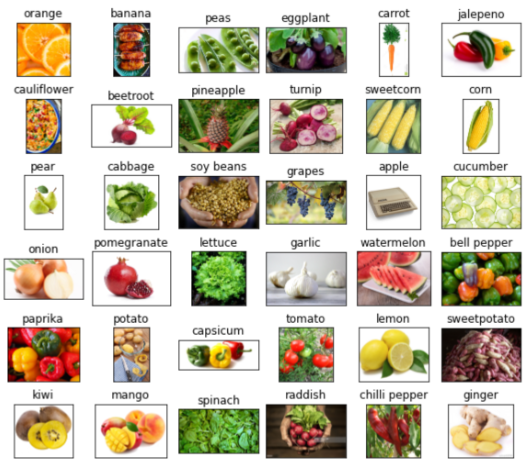

Для работы с изображениями очень хорошо подходят сверточные нейронные сети, поэтому за основу возьмем MobilenetV2, предобученную на большом количестве изображений из базы ImageNet. MobileNetV2 является облегченной глубокой нейронной сетью, которая использует сверточные блоки глубиной 53 слоя.

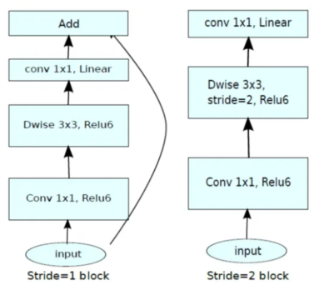

Сеть имеет 2 типа блоков: один остаточный блок с шагом 1 (на рисунке слева), другой блок с шагом 2 для уменьшения размера (на рисунке справа). 

Каждый блок имеет 3 различных слоя:
*   Свертка 1х1 имеет активационную функцию Relu6 (f(s)=max(0,6))
*   Глубинная свертка
*   Свертка 1х1 без линейной функции



Перед тем, как загружать изображения в нашу предобученную нейронную сеть, их необходимо преобразовать в формат, который принимает наша модель, то есть перевести в тензоры с плавающей точкой, а затем произвести нормализацию изображений из интервала от 0 до 255 к интервалу от 0 до 1.Это можно сделать с использованием класса ImageDataGenerator. Данный класс удобен и полезен тем, что берет изображения прямо из папок, а также позволяет расширить набор данных за счет создания копий изображений, изменяя различные свойства изображения (смещение, поворот, увеличение и т.д.). Такой подход позволяет модели лучше обобщать и извлекать различные признаки. Достаточно передать конструктору класса набор различных значений необходимых нам параметров и обо всем он позаботится сам.

In [ ]:
train_generator = ImageDataGenerator(
preprocessing_function = mobilenet_v2.preprocess_input,
rotation_range = 32,
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range = 0.2,
shear_range = 0.2,
horizontal_flip = True,
fill_mode = "nearest")
train_generator

Так как используется предобученная нейронная сеть, тогда для перевода изображений в тензоры с плавающей точкой будем использовать готовый метод mobilenet_v2.preprocess_input

Теперь воспользуемся методом .flow_from_directory для применения полученного преобразования к нашим изображениям из обучающего и валидационного набора данных.

In [ ]:
train = train_generator.flow_from_directory(train_dir,
target_size = (img_height, img_width),
# изображение имеет 3 цветовых канала
color_mode = "rgb",
# создаем бинарные признаки меток класса 
class_mode = "categorical",
batch_size = 32,
shuffle = True,
seed = 123)

validation = train_generator.flow_from_directory(val_dir,
target_size = (img_height,img_width),
# изображение имеет 3 цветовых канала
color_mode = "rgb",
# создаем бинарные признаки меток класса 
class_mode = "categorical",
batch_size = 32,
shuffle = True,
seed = 123)

test = train_generator.flow_from_directory(test_dir,
target_size = (img_height, img_width),
# изображение имеет 3 цветовых канала
color_mode = "rgb",
# создаем бинарные признаки меток класса 
class_mode = "categorical",
batch_size = 32,
shuffle = True,
seed = 123)

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


Здесь можно обратить внимание, что указан параметр shuffle = True, что говорит о том, что изображения из разных классов не будут перемешиваться. Сначала будут поступать изображения из первой папки, потом из второй и т.д, а затем из последней. Это необходимо, чтобы мы могли потом легко обращаться к меткам класса. 

Перейдем к построению модели. Загружаем предварительно обученную версию сети с размером входного изображения (224, 224, 3) с весами “imagenet”.

In [ ]:
mobilenet_ = MobileNetV2(
input_shape = (img_height, img_width, 3),
include_top = False,
weights = 'imagenet',
pooling = 'avg')

9406464/9406464 [==============================] - 1s 0us/step


Блокируем возможность изменения значений переменных предобученной модели и оставляем возможность обучаться только последним слоям классификации.

In [ ]:
mobilenet_.trainable = False

Создаем 2 обычных слоя с 128 нейронами и один последний слой классификации, с количеством нейронов равных количеству необходимых нам классов и активационной функцией softmax

In [ ]:
inputs = mobilenet_.input
x = Dense(128, activation = 'relu')(mobilenet_.output)
x = Dense(128, activation = 'relu')(x)
outputs = Dense(num_classes , activation = 'softmax')(x)

Собираем модель сети,состоящую из предобученной модели и добавленных новых слоев.

In [ ]:
mobilenet = Model(inputs = inputs, outputs = outputs)

Используем метод ModelCheckpoint для сохранения весов модели, основываясь на потерях на этапе проверки и метод EarlyStopping для ранней остановки обучения

In [ ]:
early_stopping = EarlyStopping(
	monitor='val_loss',
	mode='min',
	patience = 2,
	verbose=1,
	restore_best_weights=True,
)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Chef AI /Fruits and Vegetables Image Recognition Dataset/fruit224mobile.h5',
                        	monitor = 'val_loss',
                        	mode = 'min',
                       	save_best_only = True)

callbacks = [early_stopping, checkpoint]

Компилируем и подгоняем модель, используя оптимизатор Адама и категориальную перекрестную энтропию.

In [ ]:
mobilenet.compile(optimizer='Adam', loss ='categorical_crossentropy',metrics = ['accuracy'])

history = mobilenet.fit(
train, validation_data = validation,
batch_size = 32,
epochs = 20,
callbacks = callbacks)

Epoch 1/20
 6/98 [>.............................] - ETA: 5:17 - loss: 0.3934 - accuracy: 0.8854

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 [==============================] - 352s 4s/step - loss: 0.4227 - accuracy: 0.8591 - val_loss: 0.3071 - val_accuracy: 0.8889
Epoch 2/20
98/98 [==============================] - 343s 3s/step - loss: 0.3377 - accuracy: 0.8831 - val_loss: 0.2487 - val_accuracy: 0.9174
Epoch 3/20
98/98 [==============================] - 339s 3s/step - loss: 0.3037 - accuracy: 0.8947 - val_loss: 0.2429 - val_accuracy: 0.9202
Epoch 4/20
98/98 [==============================] - 344s 3s/step - loss: 0.2750 - accuracy: 0.9002 - val_loss: 0.3038 - val_accuracy: 0.9060
Epoch 5/20
98/98 [==============================] - 338s 3s/step - loss: 0.2649 - accuracy: 0.9117 - val_loss: 0.2529 - val_accuracy: 0.9145
Epoch 5: early stopping


Оценим модель на тестовых данных, используя метод “evaluate”

In [ ]:
(eval_loss, eval_accuracy) = mobilenet.evaluate(test)

12/12 [==============================] - 43s 4s/step - loss: 0.2507 - accuracy: 0.9164


Посмотрим на точность на тестовых значениях

In [ ]:
# получаем предсказанные значения от тестовых изображений
pred = mobilenet.predict(test)
# получаем номер класса с максимальным весом
pred = np.argmax(pred, axis=1)
# сопоставляем классы
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
# получаем предсказанные классы
y_test = [labels[k] for k in test.classes]
# оцениваем точность
from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, y_test)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Демонстрация работы модели




In [12]:
class_labels = ['Яблоко', 'Банан', 'Свекла', 'Болгарский перец', 'Капуста', 'Стручковый перец', 'Морковь', 'Цветная капуста',
               'Перец чили', 'Кукуруза', 'Огурец', 'Баклажан', 'Чеснок', 'Имбирь', 'Виноград', 'Халапеньо', 'Киви',
               'Лимон', 'Латук', 'Манго', 'Лук', 'Апельсин', 'Паприка', 'Груша', 'Горох', 'Ананас', 'Гранат',
               'Картофель', 'Редька', 'Соевые бобы', 'Шпинат', 'Сладкая кукуруза', 'Батат', 'Помидор', 'Репа', 'Арбуз']
model_path = '/content/drive/MyDrive/Chef AI /fruits and vegetables neural network/fruit224mobile.h5'

In [7]:
def predictions(img_path):
  img_size = (224, 224)
  classifier = load_model(model_path)
  try:
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    predictions_score = classifier.predict(img_array)
    likely_classes_scores = []
    likely_classes_id = []

    for i in range(predictions_score.shape[1]):
      if predictions_score[0, i] >= 0.2:
        likely_classes_id.append(i)
        likely_classes_scores.append(predictions_score[0, i])
    predicted_classes = [class_labels[i] for i in likely_classes_id ] 
    return predicted_classes, likely_classes_scores
  except Exception:
    return "Проблемы с изображением"

In [4]:
def get_img_array(img_path, size):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
  array = tf.keras.preprocessing.image.img_to_array(img)
  # расширяем размерность для преобразования массива в пакеты
  array = np.expand_dims(array, axis=0)
  return array

In [16]:
img_path = '/content/drive/MyDrive/Chef AI /cucumber_test.jpeg'
pred_classes, pred_scores = predictions(img_path)
print(f"Я думаю на изображении {pred_classes[0]}\nС точностью {pred_scores[0]}")

1/1 [==============================] - 1s 986ms/step
Я думаю на изображении Огурец
С точностью 0.9990000128746033


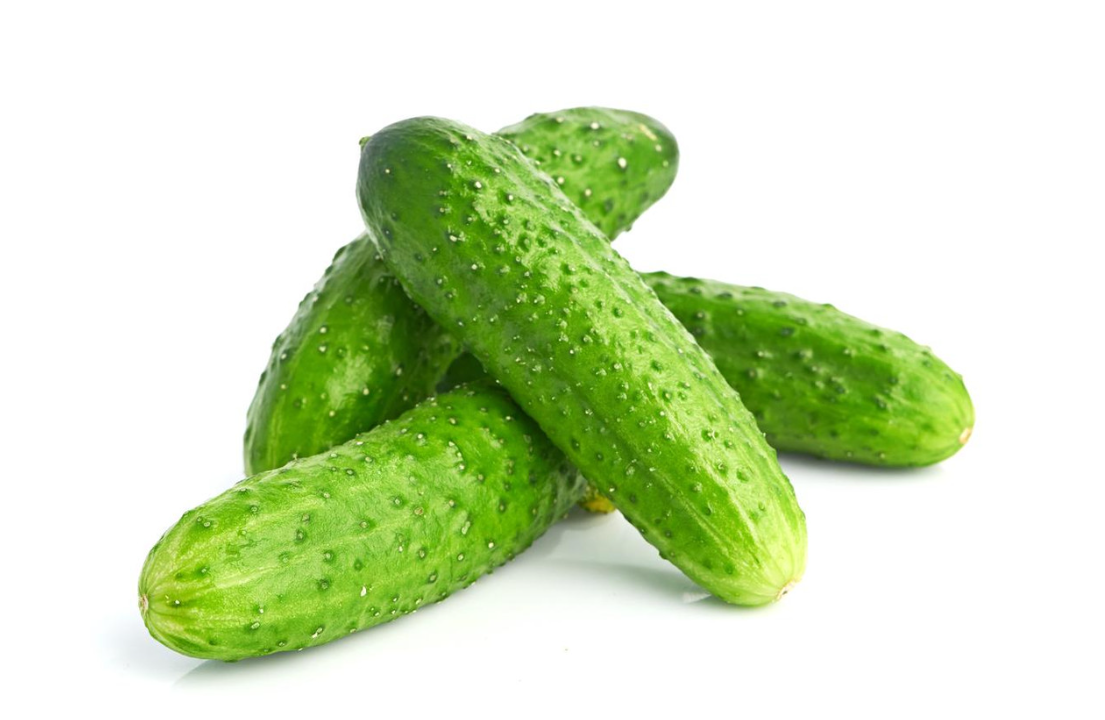